In [1]:
import numpy as np # linear algebra
import random
import torch
import math
from Bio import SeqIO
import Bio.PDB
import pickle as pickle
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.nn import GATConv
from torch_geometric.nn import GATv2Conv
from torch_geometric.nn import GENConv
from torch_geometric.nn.models import MLP
from torch_geometric.data import Data
from torch_geometric.nn.pool import SAGPooling
from torch_geometric.nn.aggr import MeanAggregation
import matplotlib.pyplot as plt
import os
from Bio import PDB
from rdkit import Chem
import blosum as bl

Be sure to edite these to reflect your file structure

In [2]:
class CFG:
    pdbfiles: str = "/home/paul/BioHack/pdbind-refined-set/"
    AA_mol2_files: str = "/home/paul/BioHack/AA_mol2/"
    home: str = '/home/paul/BioHack/'

In [4]:
with open('atom2emb.pkl', 'rb') as f:
    atom2emb = pickle.load(f)
    
with open('AA_embeddings.pkl', 'rb') as f:
    AA_embeddings = pickle.load(f)
    
with open('bond_type_dict.pkl', 'rb') as f:
    bond_type_dict = pickle.load(f)

def get_atom_symbol(atomic_number):
    return Chem.PeriodicTable.GetElementSymbol(Chem.GetPeriodicTable(), atomic_number)

def remove_hetatm(input_pdb_file, output_pdb_file):
    # Open the input PDB file for reading and the output PDB file for writing
    with open(input_pdb_file, 'r') as infile, open(output_pdb_file, 'w') as outfile:
        for line in infile:
            # Check if the line starts with 'HETATM' (non-protein atoms)
            if line.startswith('HETATM'):
                continue  # Skip this line (HETATM record)
            # Write all other lines to the output file
            outfile.write(line)
            
def get_atom_types_from_sdf(sdf_file):
    supplier = Chem.SDMolSupplier(sdf_file)
    atom_types = set()

    for mol in supplier:
        if mol is not None:
            atoms = mol.GetAtoms()
            atom_types.update([atom.GetSymbol() for atom in atoms])

    return sorted(list(atom_types))

def get_atom_types_from_mol2_split(mol2_file):
    atom_types = set()

    with open(mol2_file, 'r') as mol2:
        reading_atoms = False
        for line in mol2:
            if line.strip() == '@<TRIPOS>ATOM':
                reading_atoms = True
                continue
            elif line.strip() == '@<TRIPOS>BOND':
                break

            if reading_atoms:
                parts = line.split()
                if len(parts) >= 5:
                    atom_type = parts[5]
                    atom_types.add(atom_type)
    
    atom_types_split = set()
    for atom in atom_types:
        atom_types_split.add(str(atom).split('.')[0])
        

    return sorted(list(atom_types_split))

def get_atom_types_from_mol2(mol2_file):
    atom_types = set()

    with open(mol2_file, 'r') as mol2:
        reading_atoms = False
        for line in mol2:
            if line.strip() == '@<TRIPOS>ATOM':
                reading_atoms = True
                continue
            elif line.strip() == '@<TRIPOS>BOND':
                break

            if reading_atoms:
                parts = line.split()
                if len(parts) >= 5:
                    atom_type = parts[5]
                    atom_types.add(atom_type)

    return sorted(list(atom_types))

def get_atom_list_from_mol2_split(mol2_file):
    atoms = []
    with open(mol2_file, 'r') as mol2:
        reading_atoms = False
        for line in mol2:
            if line.strip() == '@<TRIPOS>ATOM':
                reading_atoms = True
                continue
            elif line.strip() == '@<TRIPOS>BOND':
                break

            if reading_atoms:
                parts = line.split()
                if len(parts) >= 5:
                    atom_type = parts[5]
                    atoms.append(atom_type)
    
    atom_list = []
    for atom in atoms:
        atom_list.append(str(atom).split('.')[0])
        

    return atom_list

def get_atom_list_from_mol2(mol2_file):
    atoms = []
    with open(mol2_file, 'r') as mol2:
        reading_atoms = False
        for line in mol2:
            if line.strip() == '@<TRIPOS>ATOM':
                reading_atoms = True
                continue
            elif line.strip() == '@<TRIPOS>BOND':
                break

            if reading_atoms:
                parts = line.split()
                if len(parts) >= 5:
                    atom_type = parts[5]
                    atoms.append(atom_type)

    return atoms

def get_bond_types_from_mol2(mol2_file):
    bond_types = set()

    with open(mol2_file, 'r') as mol2:
        reading_bonds = False
        for line in mol2:
            if line.strip() == '@<TRIPOS>BOND':
                reading_bonds = True
                continue
            elif reading_bonds and line.strip().startswith('@<TRIPOS>'):
                break

            if reading_bonds:
                parts = line.split()
                if len(parts) >= 4:
                    bond_type = parts[3]
                    bond_types.add(bond_type)

    return sorted(list(bond_types))

def read_mol2_bonds(mol2_file):
    bonds = []
    bond_types = []

    with open(mol2_file, 'r') as mol2:
        reading_bonds = False
        for line in mol2:
            if line.strip() == '@<TRIPOS>BOND':
                reading_bonds = True
                continue
            elif reading_bonds and line.strip().startswith('@<TRIPOS>'):
                break

            if reading_bonds:
                parts = line.split()
                if len(parts) >= 4:
                    atom1_index = int(parts[1])
                    atom2_index = int(parts[2])
                    bond_type = parts[3]
                    bonds.append((atom1_index, atom2_index))
                    bond_types.append(bond_type)

    return bonds, bond_types

def calc_residue_dist(residue_one, residue_two) :
    """Returns the C-alpha distance between two residues"""
    diff_vector  = residue_one["CA"].coord - residue_two["CA"].coord
    return np.sqrt(np.sum(diff_vector * diff_vector))

def calc_dist_matrix(chain_one, chain_two) :
    """Returns a matrix of C-alpha distances between two chains"""
    answer = np.zeros((len(chain_one), len(chain_two)), float)
    for row, residue_one in enumerate(chain_one) :
        for col, residue_two in enumerate(chain_two) :
            answer[row, col] = calc_residue_dist(residue_one, residue_two)
    return answer

def calc_contact_map(uniID,map_distance):
    pdb_code = uniID
    pdb_filename = uniID+"_pocket_clean.pdb"
    structure = Bio.PDB.PDBParser(QUIET = True).get_structure(pdb_code, (CFG.pdbfiles +'/'+pdb_code+'/'+pdb_filename))
    model = structure[0]
    flag1 = 0
    flag2 = 0
    idx = 0
    index = []
    chain_info = []
    
    for chain1 in model:
        for resi in chain1:
            index.append(idx)
            idx += 1
            chain_info.append([chain1.id,resi.id])
        for chain2 in model:
            if flag1 == 0:
                dist_matrix = calc_dist_matrix(model[chain1.id], model[chain2.id])
            else:
                new_matrix = calc_dist_matrix(model[chain1.id], model[chain2.id])
                dist_matrix = np.hstack((dist_matrix,new_matrix))
            flag1 += 1
        flag1 = 0
        if flag2 == 0:
            top_matrix = dist_matrix
        else:
            top_matrix = np.vstack((top_matrix,dist_matrix))
        flag2 += 1
    
    contact_map = top_matrix < map_distance
    return contact_map, index, chain_info

one_letter_to_three_letter_dict = {'G':'gly',
                                   'A':'ala',
                                   'V':'val',
                                   'C':'cys',
                                   'P':'pro',
                                   'L':'leu',
                                   'I':'ile',
                                   'M':'met',
                                   'W':'trp',
                                   'F':'phe',
                                   'K':'lys',
                                   'R':'arg',
                                   'H':'his',
                                   'S':'ser',
                                   'T':'thr',
                                   'Y':'tyr',
                                   'N':'asn',
                                   'Q':'gln',
                                   'D':'asp',
                                   'E':'glu'
    
}

def BLOSUM_encode_single(seq,AA_dict):
    allowed = set("gavcplimwfkrhstynqdeuogavcplimwfkrhstynqde")
    if not set(seq).issubset(allowed):
        invalid = set(seq) - allowed
        raise ValueError(f"Sequence has broken AA: {invalid}")
    vec = AA_dict[seq]
    return vec

matrix = bl.BLOSUM(62)
allowed_AA = "GAVCPLIMWFKRHSTYNQDE"
BLOSUM_dict_three_letter = {}
for i in allowed_AA:
    vec = []
    for j in allowed_AA:
        vec.append(matrix[i][j])
    BLOSUM_dict_three_letter.update({one_letter_to_three_letter_dict[i]:torch.Tensor(vec)})

def uniID2graph(uniID,map_distance):
    atom_name = 'CA'
    node_feature = []
    edge_index = []
    edge_attr = []
    coord = []
    contact_map, index, chain_info = calc_contact_map(uniID,map_distance)
    pdb_code = uniID
    pdb_filename = uniID+"_pocket_clean.pdb"
    structure = Bio.PDB.PDBParser(QUIET = True).get_structure(pdb_code, (CFG.pdbfiles +'/'+pdb_code+'/'+pdb_filename))
    model = structure[0]
    
    for i in index:
        node_feature.append(AA_embeddings[model[chain_info[i][0]][chain_info[i][1]].get_resname()])
        coord.append(model[chain_info[i][0]][chain_info[i][1]]['CA'].coord)
        for j in index:
            if contact_map[i,j] == 1:
                edge_index.append([i,j])
                diff_vector = model[chain_info[i][0]][chain_info[i][1]]['CA'].coord - model[chain_info[j][0]][chain_info[j][1]]['CA'].coord
                dist = (np.sqrt(np.sum(diff_vector * diff_vector))/map_distance)
                bond_type = bond_type_dict['nc']
                edge_attr.append(np.hstack((dist,bond_type)))
                            
    edge_index = np.array(edge_index)
    edge_index = edge_index.transpose()
    edge_index = torch.Tensor(edge_index)
    edge_index = edge_index.to(torch.int64)
    edge_attr = torch.Tensor(edge_attr)
    node_feature = torch.stack(node_feature)
    graph = Data(x = node_feature, edge_index = edge_index,edge_attr = edge_attr)
    return graph, coord

def read_mol2_bonds_and_atoms(mol2_file):
    bonds = []
    bond_types = []
    atom_types = {}
    atom_coordinates = {}

    with open(mol2_file, 'r') as mol2:
        reading_bonds = False
        reading_atoms = False
        for line in mol2:
            if line.strip() == '@<TRIPOS>BOND':
                reading_bonds = True
                continue
            elif line.strip() == '@<TRIPOS>ATOM':
                reading_atoms = True
                continue
            elif line.strip().startswith('@<TRIPOS>SUBSTRUCTURE'):
                break
            elif reading_bonds and line.strip().startswith('@<TRIPOS>'):
                reading_bonds = False
            elif reading_atoms and line.strip().startswith('@<TRIPOS>'):
                reading_atoms = False


            if reading_bonds:
                parts = line.split()
                if len(parts) >= 4:
                    atom1_index = int(parts[1])
                    atom2_index = int(parts[2])
                    bond_type = parts[3]
                    bonds.append((atom1_index, atom2_index))
                    bond_types.append(bond_type)

            if reading_atoms:
                parts = line.split()
                if len(parts) >= 6:
                    atom_index = int(parts[0])
                    atom_type = parts[5]
                    x, y, z = float(parts[2]), float(parts[3]), float(parts[4])
                    atom_types[atom_index] = atom_type.split('.')[0]
                    atom_coordinates[atom_index] = (x, y, z)

    return bonds, bond_types, atom_types, atom_coordinates

def molecule2graph(filename,map_distance):
    node_feature = []
    edge_index = []
    edge_attr = []
    mol2_file = CFG.pdbfiles+filename+'/'+filename+'_ligand.mol2'
    bonds, bond_types, atom_types, atom_coordinates = read_mol2_bonds_and_atoms(mol2_file)
    for atom in atom_types:
        #node_feature.append(torch.zeros(20))
        node_feature.append(torch.Tensor(atom2emb[atom_types[atom]]))
    for i in range(len(bonds)):
        bond = bonds[i]
        edge_index.append([bond[0] - 1,bond[1] - 1])
        coord1 = np.array(atom_coordinates[bond[0]])
        coord2 = np.array(atom_coordinates[bond[1]])
        dist = [np.sqrt(np.sum((coord1 - coord2)*(coord1 - coord2)))/map_distance]
        bond_type = bond_type_dict[bond_types[i]]
        edge_attr.append(np.hstack((dist,bond_type)))
    
    edge_index = np.array(edge_index)
    edge_index = edge_index.transpose()
    edge_index = torch.Tensor(edge_index)
    edge_index = edge_index.to(torch.int64)
    edge_attr = torch.Tensor(edge_attr)
    node_feature = torch.stack(node_feature)
    graph = Data(x = node_feature, edge_index = edge_index,edge_attr = edge_attr)
    
    return graph, atom_coordinates

def id2fullgraph(filename, map_distance):
    prot_graph, prot_coord = uniID2graph(filename,map_distance)
    prot_graph = prot_graph.to('cpu')
    mol_graph, mol_coord = molecule2graph(filename,map_distance)
    mol_graph = mol_graph.to('cpu')
    mol_coord = [mol_coord[i] for i in mol_coord]
    node_features = torch.cat((prot_graph.x,mol_graph.x),dim = 0)
    update_edge_index = mol_graph.edge_index + prot_graph.x.size()[0]
    edge_index = torch.cat((prot_graph.edge_index,update_edge_index), dim = 1)
    edge_attr = torch.cat((prot_graph.edge_attr,mol_graph.edge_attr), dim = 0)
    
    new_edge_index = []
    new_edge_attr = []
    for i in range(len(mol_coord)):
        for j in range(len(prot_coord)):
            dist_vec = mol_coord[i] - prot_coord[j]
            dist = np.sqrt(np.sum(dist_vec*dist_vec))/map_distance
            if dist < 1.0:
                new_edge_index.append([j,i + len(prot_coord)])
                new_edge_attr.append((np.hstack(([dist],bond_type_dict['nc']))))
                
    new_edge_index = np.array(new_edge_index)
    new_edge_index = new_edge_index.transpose()
    new_edge_index = torch.Tensor(new_edge_index)
    new_edge_index = new_edge_index.to(torch.int64)
    new_edge_attr = torch.Tensor(new_edge_attr)
    
    edge_index = torch.cat((edge_index,new_edge_index), dim = 1)
    edge_attr = torch.cat((edge_attr,new_edge_attr), dim = 0)
    
    graph = Data(x = node_features, edge_index = edge_index,edge_attr = edge_attr)
    
    return graph

def molecule2graph_AA(filename,map_distance):
    node_feature = []
    edge_index = []
    edge_attr = []
    mol2_file = filename
    bonds, bond_types, atom_types, atom_coordinates = read_mol2_bonds_and_atoms(mol2_file)
    for atom in atom_types:
        #node_feature.append(torch.zeros(20))
        node_feature.append(torch.Tensor(atom2emb[atom_types[atom]]))
    for i in range(len(bonds)):
        bond = bonds[i]
        edge_index.append([bond[0] - 1,bond[1] - 1])
        coord1 = np.array(atom_coordinates[bond[0]])
        coord2 = np.array(atom_coordinates[bond[1]])
        dist = [np.sqrt(np.sum((coord1 - coord2)*(coord1 - coord2)))/map_distance]
        bond_type = bond_type_dict[bond_types[i]]
        edge_attr.append(np.hstack((dist,bond_type)))
    
    #Master_node
    node_feature.append(torch.zeros(len(atom2emb['N'])))
    
    for i in range(len(node_feature) - 1):
        edge_index.append([i,int(len(node_feature)-1)])
        bond_type = bond_type_dict['1']
        edge_attr.append(np.hstack((1.0,bond_type)))
    
    edge_index = np.array(edge_index)
    edge_index = edge_index.transpose()
    edge_index = torch.Tensor(edge_index)
    edge_index = edge_index.to(torch.int64)
    edge_attr = torch.Tensor(edge_attr)
    node_feature = torch.stack(node_feature)
    graph = Data(x = node_feature, edge_index = edge_index,edge_attr = edge_attr)
    
    return graph, atom_coordinates

upper2lower = {
    "ala": "ALA",
    "arg": "ARG",
    "asn": "ASN",
    "asp": "ASP",
    "cys": "CYS",
    "gln": "GLN",
    "glu": "GLU",
    "gly": "GLY",
    "his": "HIS",
    "ile": "ILE",
    "leu": "LEU",
    "lys": "LYS",
    "met": "MET",
    "phe": "PHE",
    "pro": "PRO",
    "ser": "SER",
    "thr": "THR",
    "trp": "TRP",
    "tyr": "TYR",
    "val": "VAL",
}

In [8]:
def calc_contact_map_vx(uniID,map_distance):
    pdb_code = uniID
    pdb_filename = uniID+"_pocket_clean.pdb"
    structure = Bio.PDB.PDBParser(QUIET = True).get_structure(pdb_code, (CFG.home +'/'+pdb_code+'/'+pdb_filename))
    model = structure[0]
    flag1 = 0
    flag2 = 0
    idx = 0
    index = []
    chain_info = []
    
    for chain1 in model:
        for resi in chain1:
            index.append(idx)
            idx += 1
            chain_info.append([chain1.id,resi.id])
        for chain2 in model:
            if flag1 == 0:
                dist_matrix = calc_dist_matrix(model[chain1.id], model[chain2.id])
            else:
                new_matrix = calc_dist_matrix(model[chain1.id], model[chain2.id])
                dist_matrix = np.hstack((dist_matrix,new_matrix))
            flag1 += 1
        flag1 = 0
        if flag2 == 0:
            top_matrix = dist_matrix
        else:
            top_matrix = np.vstack((top_matrix,dist_matrix))
        flag2 += 1
    
    contact_map = top_matrix < map_distance
    return contact_map, index, chain_info

def uniID2graph_vx(uniID,map_distance):
    atom_name = 'CA'
    node_feature = []
    edge_index = []
    edge_attr = []
    coord = []
    contact_map, index, chain_info = calc_contact_map_vx(uniID,map_distance)
    pdb_code = uniID
    pdb_filename = uniID+"_pocket_clean.pdb"
    structure = Bio.PDB.PDBParser(QUIET = True).get_structure(pdb_code, (CFG.home +'/'+pdb_code+'/'+pdb_filename))
    model = structure[0]
    
    for i in index:
        node_feature.append(AA_embeddings[model[chain_info[i][0]][chain_info[i][1]].get_resname()])
        coord.append(model[chain_info[i][0]][chain_info[i][1]]['CA'].coord)
        for j in index:
            if contact_map[i,j] == 1:
                edge_index.append([i,j])
                diff_vector = model[chain_info[i][0]][chain_info[i][1]]['CA'].coord - model[chain_info[j][0]][chain_info[j][1]]['CA'].coord
                dist = (np.sqrt(np.sum(diff_vector * diff_vector))/map_distance)
                bond_type = bond_type_dict['nc']
                edge_attr.append(np.hstack((dist,bond_type)))
                            
    edge_index = np.array(edge_index)
    edge_index = edge_index.transpose()
    edge_index = torch.Tensor(edge_index)
    edge_index = edge_index.to(torch.int64)
    edge_attr = torch.Tensor(edge_attr)
    node_feature = torch.stack(node_feature)
    graph = Data(x = node_feature, edge_index = edge_index,edge_attr = edge_attr)
    return graph, coord


def molecule2graph_vx(filename,map_distance):
    node_feature = []
    edge_index = []
    edge_attr = []
    mol2_file = CFG.home+filename+'/'+filename+'_ligand.mol2'
    bonds, bond_types, atom_types, atom_coordinates = read_mol2_bonds_and_atoms(mol2_file)
    for atom in atom_types:
        #node_feature.append(torch.zeros(20))
        node_feature.append(torch.Tensor(atom2emb[atom_types[atom]]))
    for i in range(len(bonds)):
        bond = bonds[i]
        edge_index.append([bond[0] - 1,bond[1] - 1])
        coord1 = np.array(atom_coordinates[bond[0]])
        coord2 = np.array(atom_coordinates[bond[1]])
        dist = [np.sqrt(np.sum((coord1 - coord2)*(coord1 - coord2)))/map_distance]
        bond_type = bond_type_dict[bond_types[i]]
        edge_attr.append(np.hstack((dist,bond_type)))
    
    edge_index = np.array(edge_index)
    edge_index = edge_index.transpose()
    edge_index = torch.Tensor(edge_index)
    edge_index = edge_index.to(torch.int64)
    edge_attr = torch.Tensor(edge_attr)
    node_feature = torch.stack(node_feature)
    graph = Data(x = node_feature, edge_index = edge_index,edge_attr = edge_attr)
    
    return graph, atom_coordinates

def id2fullgraph_vx(filename, map_distance):
    prot_graph, prot_coord = uniID2graph_vx(filename,map_distance)
    prot_graph = prot_graph.to('cpu')
    mol_graph, mol_coord = molecule2graph_vx(filename,map_distance)
    mol_graph = mol_graph.to('cpu')
    mol_coord = [mol_coord[i] for i in mol_coord]
    node_features = torch.cat((prot_graph.x,mol_graph.x),dim = 0)
    update_edge_index = mol_graph.edge_index + prot_graph.x.size()[0]
    edge_index = torch.cat((prot_graph.edge_index,update_edge_index), dim = 1)
    edge_attr = torch.cat((prot_graph.edge_attr,mol_graph.edge_attr), dim = 0)
    
    new_edge_index = []
    new_edge_attr = []
    for i in range(len(mol_coord)):
        for j in range(len(prot_coord)):
            dist_vec = mol_coord[i] - prot_coord[j]
            dist = np.sqrt(np.sum(dist_vec*dist_vec))/map_distance
            if dist < 1.0:
                new_edge_index.append([j,i + len(prot_coord)])
                new_edge_attr.append((np.hstack(([dist],bond_type_dict['nc']))))
                
    new_edge_index = np.array(new_edge_index)
    new_edge_index = new_edge_index.transpose()
    new_edge_index = torch.Tensor(new_edge_index)
    new_edge_index = new_edge_index.to(torch.int64)
    new_edge_attr = torch.Tensor(new_edge_attr)
    
    edge_index = torch.cat((edge_index,new_edge_index), dim = 1)
    edge_attr = torch.cat((edge_attr,new_edge_attr), dim = 0)
    
    graph = Data(x = node_features, edge_index = edge_index,edge_attr = edge_attr)
    graph.label = filename
    
    return graph

Create the graph for the Vx Binder (Skip this and just load in the graph I precomputed)

In [56]:
#graph = id2fullgraph_vx('Vx_binder', 12.0)

In [57]:
#designable_indicies = [5,8,12,22,26,29,41,44,48,58,62,65]

In [58]:
#graph.mask = [True if i in designable_indicies else False for i in range(graph.x.size()[0])]

In [60]:
#torch.save(graph, 'vx_graph.pt')

In [ ]:
graph = torch.load('vx_graph.pt')

# Define a Model to Classify Amino Acids (This is the Model we are trying to build. I just inserted a quick stand in to make the script work)

In [41]:
class AA_classification(torch.nn.Module):
    def __init__(self):
        super(AA_classification, self).__init__()
        self.node_feature_size = 133
        self.node_feature_hidden_size = 50
        self.node_feature_size_out = 133
        self.conv1 = GENConv(self.node_feature_size,self.node_feature_hidden_size,aggr = 'mean',edge_dim = 7,num_layer = 3) 
        self.conv2 = GENConv(self.node_feature_hidden_size,self.node_feature_size_out,aggr = 'mean',edge_dim = 7,num_layer = 3)
        self.ReLu = nn.ReLU()
        self.tanh = nn.Tanh()
        
    def forward(self,graph):
        x, edge_index, edge_attr = graph.x,graph.edge_index,graph.edge_attr
        x1 = self.conv1(x, edge_index,edge_attr)
        x1 = self.ReLu(x1)
        x1 = self.conv2(x1, edge_index,edge_attr)
        x1 = self.tanh(x1)

        return x1

Run the model and get our predictions

In [42]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = AA_classification()
#model.to(DEVICE)

with torch.no_grad():
    
    #Mask Designable Site
    for i,indicator in enumerate(graph.mask):
        if indicator == True:
            graph.x[i] = torch.zeros(len(graph.x[0]))
    
    #Run Model
    output = model(graph)

Load AA Decoder

In [43]:
class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.node_feature_size = 133
        self.node_feature_hidden_size = 50
        self.node_feature_size_out = 20
        self.dropout = 0.3
        self.conv1 = GENConv(self.node_feature_size,self.node_feature_hidden_size,aggr = 'mean',edge_dim = 7,num_layer = 3)
        self.conv2 = GATv2Conv(self.node_feature_hidden_size,10, edge_dim = 7, heads = 5,concat = True, dropout = self.dropout)
        self.conv3 = GENConv(self.node_feature_hidden_size,self.node_feature_hidden_size,aggr = 'mean',edge_dim = 7,num_layer = 3)
        self.conv4 = GATv2Conv(self.node_feature_hidden_size,self.node_feature_size, edge_dim = 7, heads = 5,concat = False, dropout = self.dropout)
        self.drop = nn.Dropout(p = 0.3)
        self.linear1 = nn.Linear(self.node_feature_size,self.node_feature_hidden_size)
        self.linear2 = nn.Linear(self.node_feature_hidden_size,self.node_feature_hidden_size)
        self.linear3 = nn.Linear(self.node_feature_hidden_size,self.node_feature_size_out)
        self.ReLu = nn.ReLU()
        self.softmax = torch.nn.Softmax(dim=1)

    def forward(self,graph):
        x, edge_index, edge_attr = graph.x,graph.edge_index,graph.edge_attr
        x1 = self.conv1(x, edge_index,edge_attr)
        x1 = self.ReLu(x1)
        x1 = self.conv2(x1, edge_index,edge_attr)
        x1 = self.ReLu(x1)
        x1 = self.conv3(x1, edge_index,edge_attr)
        x1 = self.ReLu(x1)
        x1 = self.conv4(x1, edge_index,edge_attr)
        x1 = x1[-1]
        x1 = torch.tanh(x1)
        x1 = self.drop(x1)
        x1 = self.linear1(x1)
        x1 = self.drop(x1)
        x1 = self.ReLu(x1)
        x1 = self.linear2(x1)
        x1 = self.ReLu(x1)
        x1 = self.linear3(x1)
        return x1
    
    def encode(self,graph):
        x, edge_index, edge_attr = graph.x,graph.edge_index,graph.edge_attr
        x1 = self.conv1(x, edge_index,edge_attr)
        x1 = self.ReLu(x1)
        x1 = self.conv2(x1, edge_index,edge_attr)
        x1 = self.ReLu(x1)
        x1 = self.conv3(x1, edge_index,edge_attr)
        x1 = self.ReLu(x1)
        x1 = self.conv4(x1, edge_index,edge_attr)
        x1 = x1[-1]
        x1 = torch.tanh(x1)
        return x1
    
    def decode(self,encoding):
        x1 = self.linear1(encoding)
        x1 = self.drop(x1)
        x1 = self.ReLu(x1)
        x1 = self.linear2(x1)
        x1 = self.ReLu(x1)
        x1 = self.linear3(x1)
        return x1

Use the decoder to determine which AA is predicted at each site

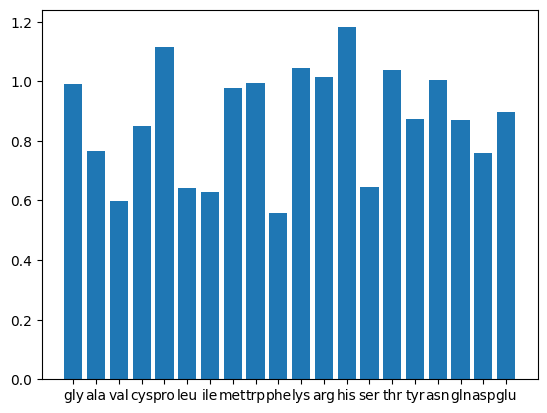

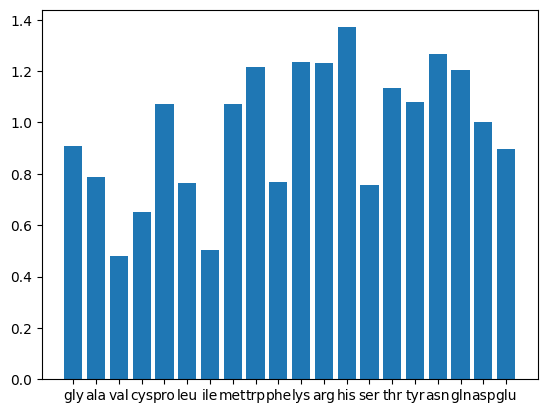

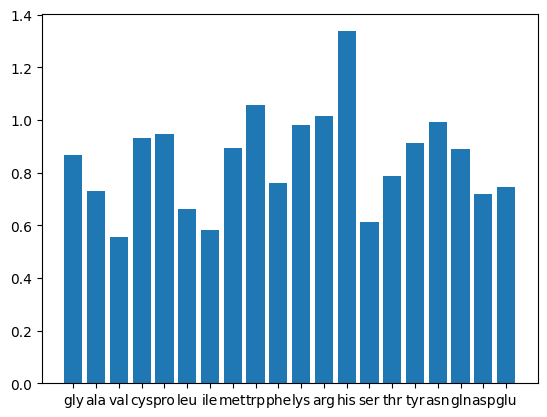

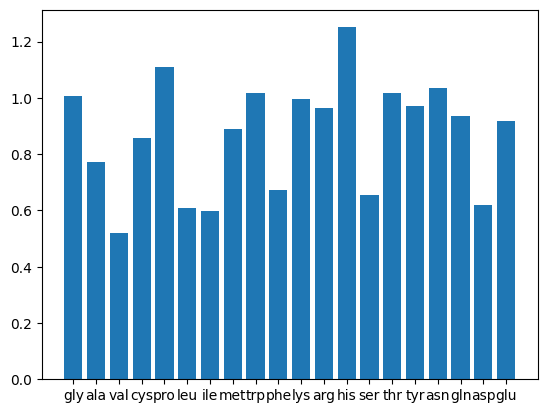

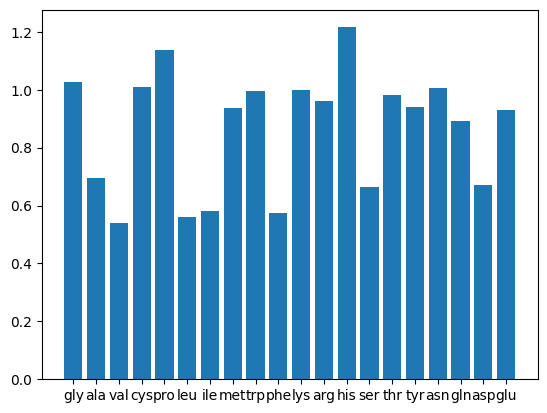

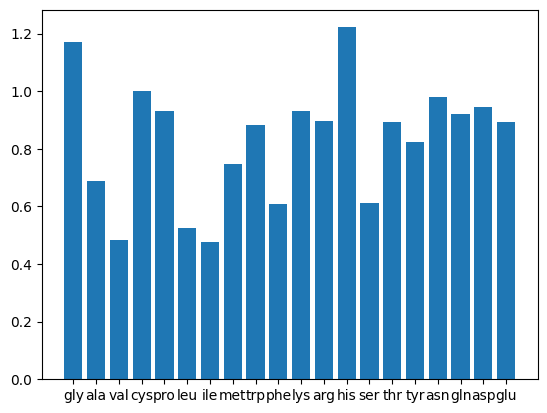

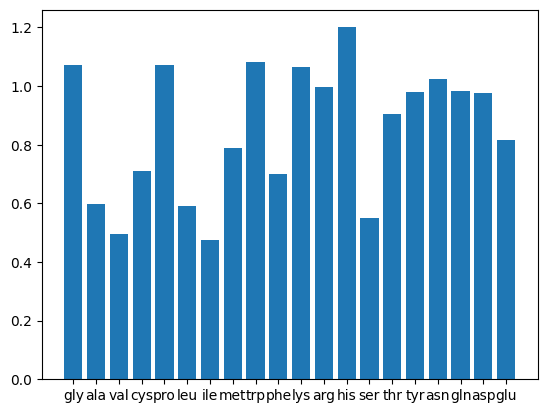

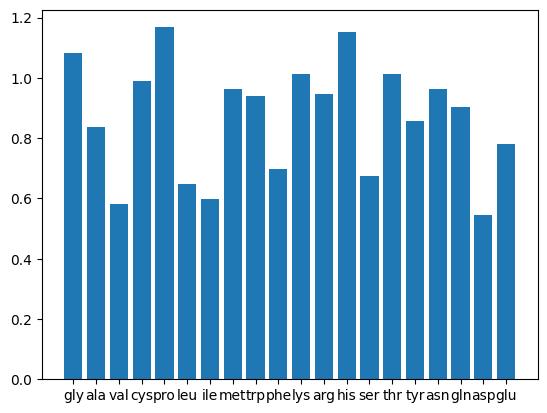

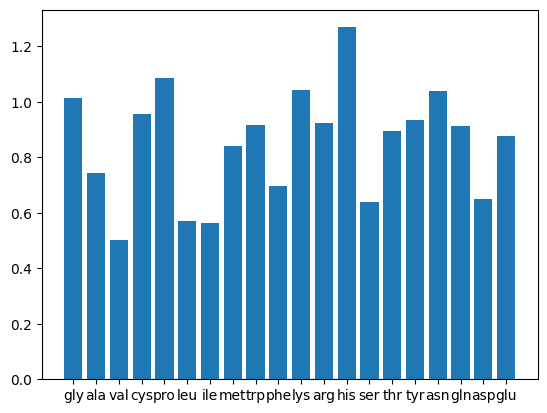

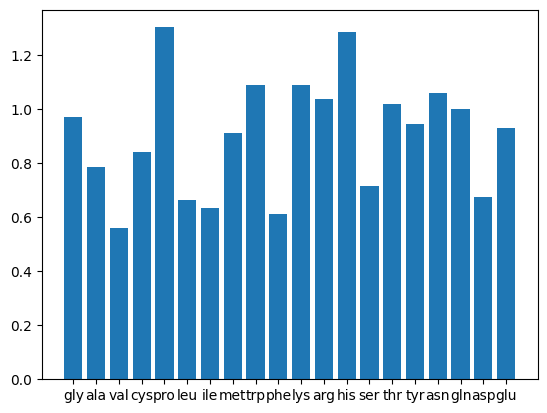

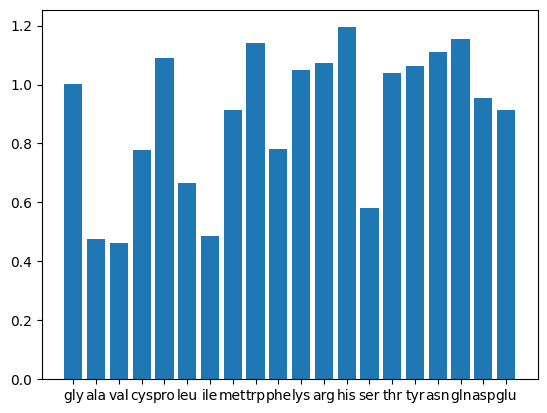

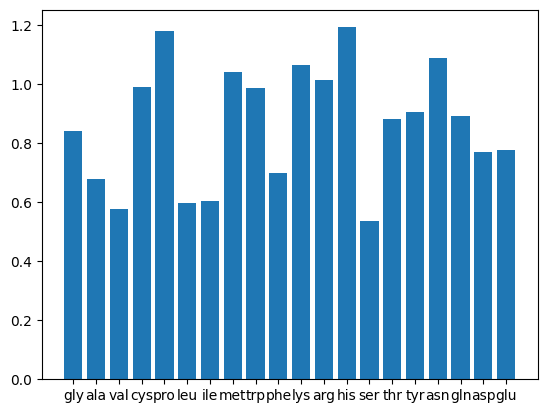

In [55]:
decoder = Net()
decoder = torch.load('AA_encoder')
decoder.to('cpu')

#AAs to Decode
predictions = output[graph.mask]

decoded_AAs = [decoder.decode(AA) for AA in predictions]

Amino_Acid_x_label = [i for i in BLOSUM_dict_three_letter]


softmax = nn.Softmax(dim = 0)
for site, AA in enumerate(decoded_AAs):
    dist = []
    for i in BLOSUM_dict_three_letter:
        BLOSUM = softmax(BLOSUM_dict_three_letter[i]).detach().numpy()
        dist.append(np.sum((BLOSUM - AA.detach().numpy())*(BLOSUM - AA.detach().numpy())))
    plt.bar(Amino_Acid_x_label,dist)
    plt.show()